## Data preprocessing

Let's start off by preprocessing our data.
Just run the code, it will download the dataset and do all the things for you.
We have a table of movies which includes genres and tags. Tags stored as another table that has relevances associated with each tag. The main idea I imply here is that I sort tag by -relevance (in descending order) and put them in string. Then I split the genres (which are listed separated by |) and prepend them to the start of the line.
Just run the code and see the final table, nothing profusely educating here.

### Movies

In [1]:
import zipfile
import wget
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from pytorch_pretrained_bert import BertTokenizer, BertModel

files = dict()
url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'  
path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
zippath = os.path.join(path, 'ml-20m.zip')
if not os.path.isfile(zippath):
    wget.download(url, path)
    zip_ref = zipfile.ZipFile(zippath, 'r')
    zip_ref.extractall(path)
    zip_ref.close()
path = os.path.join(path, 'ml-20m')
print('reading csv:', os.listdir(path))
for file in tqdm(os.listdir(path)):
        if file.endswith('.csv'):
            files[file.split('.')[0]] = pd.read_csv(os.path.join(path, file))

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.
reading csv: ['genome-scores.csv', 'genome-tags.csv', 'links.csv', 'movies.csv', 'ratings.csv', 'ratings_by_user.p', 'README.txt', 'tags.csv']


In [2]:
from pytorch_pretrained_bert import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
def reverse_respect_sort(X, Y):
    return list(reversed([x for _, x in sorted(zip(Y,X), key=lambda pair: pair[0])]))

def get_tags(t, max_tags):
    tags = dict()
    tags['relevance'] = t['relevance'].tolist()
    tags['tag'] = t['tag'].tolist()

    tags = reverse_respect_sort(tags['tag'], tags['relevance'])[:max_tags]
    tags = ' '.join(tags)
    return tags

def data_processor(files):
    files['user-tags'] = files['tags']
    files['tags'] = files['genome-scores'].merge(files['genome-tags'], left_on='tagId',
                                                   right_on='tagId', how='inner')
    del files['genome-scores']
    del files['genome-tags']
    del files['links']
    files['tags'] = files['tags'].sort_values(by=['movieId', 'tagId']).reset_index(drop=True)
    files['ratings'] = files['ratings'].sort_values(by=['userId', 'timestamp']).reset_index(drop=True)
    
    titles = files['movies']['title'].map(lambda s: s[:s.find("(")])
    
    del files['movies']['title']
    files['movies']['title'] = titles
    return files
    
files = data_processor(files)

In [4]:
import torch
cuda = torch.device('cuda')
bert = BertModel.from_pretrained('bert-base-uncased').to(cuda)

all_movies_id = files['movies']['movieId'].tolist()
max_tags = 50

data_films = pd.DataFrame()

infos = []

for m in tqdm(all_movies_id):
    movie = files['movies'].loc[all_movies_id.index(m)]
    
    tags = files['tags'].loc[files['tags']['movieId'] == m]
    tags = get_tags(tags, max_tags)
    genres = ' '.join(movie['genres'].split('|'))
    
    total = dict()
    total['id'] = movie['movieId']
    total['info'] = movie['title'] + ' ' + genres + ' ' + tags
    total['info'] = tokenizer.tokenize(total['info'])
    info = tokenizer.convert_tokens_to_ids(total['info'])
    info =torch.tensor([info]).to(cuda)
    
    _, info_encoded = bert(info)
    
    info_encoded = info_encoded.detach().cpu()
    
    #total = pd.DataFrame(total, index=[0])
    #data_films = data_films.append(total, ignore_index=True)
    
    infos.append(info_encoded)

In [3]:
import pickle
id_to_index = dict([(id, idx) for id, idx in zip(data_films['id'].tolist(), data_films.index.tolist())])
pickle.dump(id_to_index, open("../data/id_to_index.p", "wb"))

In [7]:
data_films.head()

,id,info
0,1,"['toy', 'story', 'adventure', 'animation', 'ch..."
1,2,"['ju', '##man', '##ji', 'adventure', 'children..."
2,3,"['gr', '##ump', '##ier', 'old', 'men', 'comedy..."
3,4,"['waiting', 'to', 'ex', '##hale', 'comedy', 'd..."
4,5,"['father', 'of', 'the', 'bride', 'part', 'ii',..."


In [8]:
data_films.to_csv('../data/movies.csv',index=False)

### Users 
Huge thanks to [this question](https://stackoverflow.com/questions/40357434/pandas-df-iterrow-parallelization)

In [12]:
ratings = pd.read_csv('../data/ml-20m/ratings.csv')
users = set(ratings['userId'])
ratings_by_user = dict([(i, pd.DataFrame()) for i in users])
for u in tqdm(list(users)):
            ratings_by_user[u] = ratings.loc[ratings['userId'] == u].sort_values(by='timestamp').reset_index(drop=True)

In [13]:
pickle.dump(ratings_by_user, open("../data/ratings_by_user.p", "wb"))

### Data Loader

That is the part you need to pay at least some attention to. Note: it is highly Pytorch specific.
Also I reccomend you to restart the notebook at that point.

The main idea in our dataloader being that we have some moving frame capturing news:
todo: add illustration

In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from collections import deque
import pickle

In [2]:
# File loading
with open( "../data/id_to_index.p", "rb") as f:
    id_to_index = pickle.load(f)
    
with open( "../data/ratings_by_user.p", "rb") as f:
    ratings_by_user = pickle.load(f)
movies = pd.read_csv('../data/movies.csv')

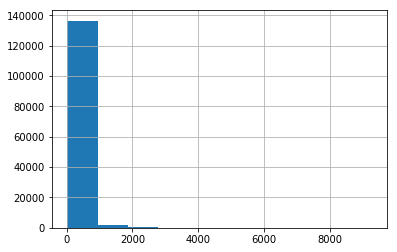

In [23]:
pd.Series(list(sorted([ len(ratings_by_user[i]) for i in list(ratings_by_user.keys())]))).hist()

In [12]:
class ML20mDataset(Dataset):
    def __init__(self, files, frame_size, id_to_index):
        self.movies, self.ratings = files
        self.id_to_index = id_to_index
        self.users = list(self.ratings.keys())
        self.user = self.users[0]
        self.frame_size = frame_size
        
    def set_user(self, u):
        # assert u in self.users
        # I commented it out because it seemed to be slowing stuff down
        self.user = u
        
    def __len__(self):
        return len(self.ratings[self.user]) - self.frame_size + 1
    
    def __getitem__(self, idx):
        return self.ratings[self.user][idx:self.frame_size+idx]

    

In [ ]:
for u in tqdm(dataset.users):
    dataset.set_user(u)
    for b_n in range(len(dataset)):
        b = dataset[b_n] 

In [5]:
stacked = torch.stack(infos)

In [8]:
stacked = torch.squeeze(stacked)
stacked.size()

torch.Size([27278, 768])

In [9]:
torch.save(stacked, '../data/movie_emb.pt')